### Deliverable 3: Optimize the Model

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', 'NAME'], axis=1)
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [3]:
# Look into shape of DataFrame and see if there are any null values
application_df.isna().sum()

APPLICATION_TYPE          0
AFFILIATION               0
CLASSIFICATION            0
USE_CASE                  0
ORGANIZATION              0
STATUS                    0
INCOME_AMT                0
SPECIAL_CONSIDERATIONS    0
ASK_AMT                   0
IS_SUCCESSFUL             0
dtype: int64

In [4]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [5]:
# Look at APPLICATION_TYPE value counts for binning
app_type_count = application_df['APPLICATION_TYPE'].value_counts()
app_type_count

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

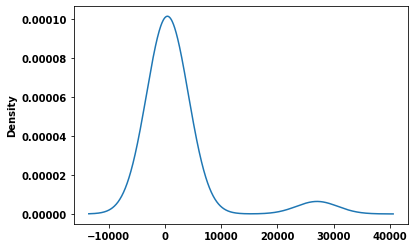

In [6]:
# Visualize the value counts of APPLICATION_TYPE
app_type_count.plot.density()

In [7]:
# Determine which values to replace if counts are less than ...?
replace_application = list(app_type_count[app_type_count <500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [8]:
# Look at CLASSIFICATION value counts for binning

class_values = application_df['CLASSIFICATION']

classification_counts = application_df['CLASSIFICATION'].value_counts()
classification_counts.head(20)

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
Name: CLASSIFICATION, dtype: int64

<AxesSubplot:ylabel='Density'>

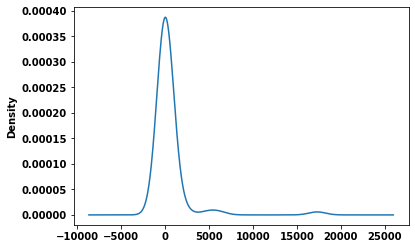

In [9]:
# Visualize the value counts of CLASSIFIICATION
classification_counts.plot.density()

In [10]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_counts[classification_counts <1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

## ATTEMPT 1

In [11]:
### MODIFICATION 1: Parse and Evaluate to keep or bin`INCOME_AMT` (Noisy Variable)

In [12]:
# Create list of columns to discover if there are any null values
income_counts = application_df.INCOME_AMT.value_counts()
income_counts

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

70% of organizations have 0 income, which is logically sensible considering these clinets are non-profit organizations. One could either replace the column all together or reduce the number of unique values to "0" or "other". This will ensure that this feature and the imbalanced distribution of classifiers and the integer amounts doesn't muddy or confuse the model.

<AxesSubplot:ylabel='Density'>

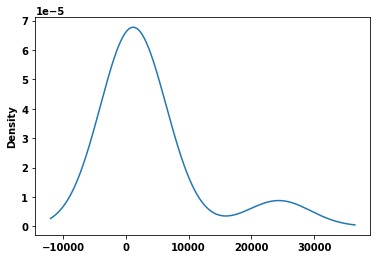

In [13]:
# Plot the distribution of `INCOME_AMT` values 
income_counts.plot.density()

In [14]:
# Reducing number of unique values to two bins("0 income and other")
replace_income = list(income_counts[income_counts <10000].index)

# Create a copy of the DataFrame for iterable purposes
application_df1 = application_df.copy()

# Replace in dataframe
for income in replace_income:
    application_df1.INCOME_AMT = application_df1.INCOME_AMT.replace(income,"Other")
    
# Check to make sure binning was successful
application_df1.INCOME_AMT.value_counts()

0        24388
Other     9911
Name: INCOME_AMT, dtype: int64

In [15]:
### MODIFICATION 2: Drop add'l non-beneficial column: 'STATUS'

In [16]:
# Look at STATUS value counts for binning or dropping the column
status_counts = application_df1['STATUS'].value_counts()
status_counts

1    34294
0        5
Name: STATUS, dtype: int64

In [17]:
application_df1 = application_df1.drop(['STATUS'],1)
application_df1.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,Other,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,Other,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,Other,N,142590,1


In [18]:
### MODIFICATION 3: Evaluate Possible Drop add'l non-beneficial column: 'SPECIAL_CONSIDERATIONS'
special_counts = application_df1.SPECIAL_CONSIDERATIONS.value_counts()
special_counts

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

In [19]:
# Filter dataframe to show column values for only organizations that are classified as SPECIAL_CONSIDERATIONS
# to determine whether to remove column in entirity (noisy data or valuable outlliers?)
Y_df = application_df1[application_df1['SPECIAL_CONSIDERATIONS'] == 'Y']
Y_df
# OVERALL, NOT A LOT OF VARIETY IN THESE FEATURES, CAN BE TREATED AS A OUTLIER CLUSTER

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
1374,T3,Independent,C2000,Preservation,Association,0,Y,5000,0
2928,T3,Independent,C1000,Preservation,Trust,Other,Y,7287,1
6056,T3,Independent,Other,Preservation,Trust,0,Y,5000,1
6805,T3,Independent,C1000,Preservation,Trust,Other,Y,5000,1
7747,T3,Independent,C1000,Preservation,Trust,0,Y,5000,0
9437,T3,Independent,C1000,Preservation,Trust,0,Y,5000,1
9941,T3,Independent,C1000,Preservation,Trust,Other,Y,53897,0
12318,T3,Independent,C1000,Preservation,Trust,Other,Y,7416,1
13998,T3,Independent,C1200,Preservation,Trust,0,Y,5000,0
14575,T3,Independent,C1000,Preservation,Trust,Other,Y,15503,0


In [20]:
# Drop non-beneficial column "SPECIAL_CONSIDERATIONS"
application_df1 = application_df1.drop(["SPECIAL_CONSIDERATIONS"], 1)
application_df1.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,Other,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,Other,6692,1
4,T3,Independent,C1000,Heathcare,Trust,Other,142590,1


In [21]:
# Generate our categorical variable lists
application_cat = application_df1.dtypes[application_df1.dtypes == "object"].index.tolist()

# Confirm number of unique values for each category variable
application_df1[application_cat].nunique()

APPLICATION_TYPE    9
AFFILIATION         6
CLASSIFICATION      6
USE_CASE            5
ORGANIZATION        4
INCOME_AMT          2
dtype: int64

In [22]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df1[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_Other
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [23]:
# Merge one-hot encoded features and drop the originals
application_df1 = application_df1.merge(encode_df, left_index=True, right_index=True)
application_df1 = application_df1.drop(application_cat, 1)
application_df1.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_Other
0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [24]:
# Split our preprocessed data into our features and target arrays
X = application_df1.drop(['IS_SUCCESSFUL'], 1).values
y = application_df1['IS_SUCCESSFUL'].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
len(X_train_scaled[0])

33

In [27]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 60
hidden_nodes_layer2 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                2040      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints_opt1/",exist_ok=True)
checkpoint_path = "checkpoints_opt1/weights.{epoch:02d}.hdf5"

In [30]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4020)

In [31]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.5737 - accuracy: 0.7155: 0s - loss: 0.5794 
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5604 - accuracy: 0.7229
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5577 - accuracy: 0.7255
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5564 - accuracy: 0.7262
Epoch 5/100
804/804 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7266
Epoch 00005: saving model to checkpoints_opt1\weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5553 - accuracy: 0.7266
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5545 - accuracy: 0.7271
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5538 - accuracy: 0.7268
Epoch 8/100
804/804 [==============================] - 1s 979us/step - loss: 0.5536 - accuracy: 0.7269
Epoch 9/100
804/804 [==

804/804 [==============================] - 2s 3ms/step - loss: 0.5436 - accuracy: 0.7343
Epoch 62/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5437 - accuracy: 0.7339
Epoch 63/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5433 - accuracy: 0.7345
Epoch 64/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5437 - accuracy: 0.7348
Epoch 65/100
785/804 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.7341
Epoch 00065: saving model to checkpoints_opt1\weights.65.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5435 - accuracy: 0.7341
Epoch 66/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5435 - accuracy: 0.7348
Epoch 67/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5430 - accuracy: 0.7348
Epoch 68/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5430 - accuracy: 0.7349
Epoch 69/100
804/804 [============================

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5581 - accuracy: 0.7266
Loss: 0.558056116104126, Accuracy: 0.7266472578048706


<AxesSubplot:>

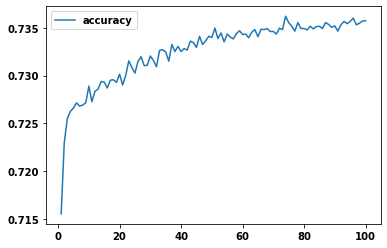

In [33]:
# Plot Accuracy
history_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))
history_df.plot(y="accuracy")

In [34]:
# Export our model to an HDF5 file
nn.save("AlphabetSoupCharity_Optimization1.h5")

### ATTEMPT 2: Keep attempt 1 dataframe modifications but:
* increase number of epochs
* number of hidden layers
* Return to original neuron count

In [35]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80)                2720      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 5,471
Trainable params: 5,471
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [37]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_opt2/",exist_ok=True)
checkpoint_path = "checkpoints_opt2/weights.{epoch:02d}.hdf5"

In [38]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4020)

In [39]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=500, callbacks=[cp_callback])

Epoch 1/500
804/804 [==============================] - 5s 4ms/step - loss: 0.5717 - accuracy: 0.7190
Epoch 2/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5585 - accuracy: 0.7259: 0s - l
Epoch 3/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5562 - accuracy: 0.7230
Epoch 4/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5555 - accuracy: 0.7260
Epoch 5/500
797/804 [============================>.] - ETA: 0s - loss: 0.5539 - accuracy: 0.7257
Epoch 00005: saving model to checkpoints_opt2\weights.05.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5541 - accuracy: 0.7256
Epoch 6/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5537 - accuracy: 0.7271
Epoch 7/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5525 - accuracy: 0.7268
Epoch 8/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5518 - accuracy: 0.7276
Epoch 9/500
804/804 [================

804/804 [==============================] - 3s 3ms/step - loss: 0.5428 - accuracy: 0.7334
Epoch 63/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5424 - accuracy: 0.7346
Epoch 64/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5426 - accuracy: 0.7343
Epoch 65/500
795/804 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.7362
Epoch 00065: saving model to checkpoints_opt2\weights.65.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5423 - accuracy: 0.7360
Epoch 66/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5428 - accuracy: 0.7342
Epoch 67/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5424 - accuracy: 0.7354
Epoch 68/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5422 - accuracy: 0.7350
Epoch 69/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5422 - accuracy: 0.7352
Epoch 70/500
793/804 [============================

804/804 [==============================] - 3s 4ms/step - loss: 0.5399 - accuracy: 0.7374
Epoch 125/500
794/804 [============================>.] - ETA: 0s - loss: 0.5399 - accuracy: 0.7361
Epoch 00125: saving model to checkpoints_opt2\weights.125.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5399 - accuracy: 0.7361
Epoch 126/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5403 - accuracy: 0.7362
Epoch 127/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5397 - accuracy: 0.7370
Epoch 128/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5396 - accuracy: 0.7364
Epoch 129/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5396 - accuracy: 0.7372
Epoch 130/500
801/804 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.7369
Epoch 00130: saving model to checkpoints_opt2\weights.130.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5397 - accuracy: 0.73

797/804 [============================>.] - ETA: 0s - loss: 0.5374 - accuracy: 0.7361
Epoch 00185: saving model to checkpoints_opt2\weights.185.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5381 - accuracy: 0.7355
Epoch 186/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5388 - accuracy: 0.7355
Epoch 187/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5387 - accuracy: 0.7361
Epoch 188/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5386 - accuracy: 0.7371: 0s - loss: 0.5397 - accura
Epoch 189/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5386 - accuracy: 0.7377
Epoch 190/500
802/804 [============================>.] - ETA: 0s - loss: 0.5388 - accuracy: 0.7372
Epoch 00190: saving model to checkpoints_opt2\weights.190.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5387 - accuracy: 0.7372
Epoch 191/500
804/804 [==============================] - 3s 4ms/step - l

804/804 [==============================] - 3s 3ms/step - loss: 0.5386 - accuracy: 0.7375
Epoch 246/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5375 - accuracy: 0.7375
Epoch 247/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5379 - accuracy: 0.7379
Epoch 248/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5376 - accuracy: 0.7374
Epoch 249/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5378 - accuracy: 0.7377
Epoch 250/500
796/804 [============================>.] - ETA: 0s - loss: 0.5383 - accuracy: 0.7378
Epoch 00250: saving model to checkpoints_opt2\weights.250.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5383 - accuracy: 0.7378
Epoch 251/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5387 - accuracy: 0.7374
Epoch 252/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5376 - accuracy: 0.7377
Epoch 253/500
804/804 [===================

804/804 [==============================] - 3s 4ms/step - loss: 0.5374 - accuracy: 0.7389
Epoch 308/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5376 - accuracy: 0.7379
Epoch 309/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5384 - accuracy: 0.7382
Epoch 310/500
800/804 [============================>.] - ETA: 0s - loss: 0.5371 - accuracy: 0.7382
Epoch 00310: saving model to checkpoints_opt2\weights.310.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5370 - accuracy: 0.7382
Epoch 311/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5373 - accuracy: 0.7375
Epoch 312/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5370 - accuracy: 0.7382
Epoch 313/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5374 - accuracy: 0.7382
Epoch 314/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5374 - accuracy: 0.7383
Epoch 315/500
804/804 [===================

804/804 [==============================] - 3s 4ms/step - loss: 0.5369 - accuracy: 0.7382
Epoch 368/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5377 - accuracy: 0.7380
Epoch 369/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5379 - accuracy: 0.7385
Epoch 370/500
797/804 [============================>.] - ETA: 0s - loss: 0.5370 - accuracy: 0.7380
Epoch 00370: saving model to checkpoints_opt2\weights.370.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5369 - accuracy: 0.7379
Epoch 371/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5370 - accuracy: 0.7373
Epoch 372/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5371 - accuracy: 0.7381
Epoch 373/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5373 - accuracy: 0.7386
Epoch 374/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5374 - accuracy: 0.7387
Epoch 375/500
795/804 [===================

Epoch 429/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5371 - accuracy: 0.7379
Epoch 430/500
795/804 [============================>.] - ETA: 0s - loss: 0.5365 - accuracy: 0.7385
Epoch 00430: saving model to checkpoints_opt2\weights.430.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5370 - accuracy: 0.7381
Epoch 431/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5372 - accuracy: 0.7378
Epoch 432/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5373 - accuracy: 0.7378
Epoch 433/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5376 - accuracy: 0.7383
Epoch 434/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5368 - accuracy: 0.7374
Epoch 435/500
796/804 [============================>.] - ETA: 0s - loss: 0.5374 - accuracy: 0.7380
Epoch 00435: saving model to checkpoints_opt2\weights.435.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5375 - 

798/804 [============================>.] - ETA: 0s - loss: 0.5365 - accuracy: 0.7387
Epoch 00490: saving model to checkpoints_opt2\weights.490.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5364 - accuracy: 0.7385
Epoch 491/500
804/804 [==============================] - 22s 27ms/step - loss: 0.5368 - accuracy: 0.7383
Epoch 492/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5364 - accuracy: 0.7380
Epoch 493/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5365 - accuracy: 0.7384
Epoch 494/500
804/804 [==============================] - 4s 4ms/step - loss: 0.5366 - accuracy: 0.7376
Epoch 495/500
802/804 [============================>.] - ETA: 0s - loss: 0.5368 - accuracy: 0.7382
Epoch 00495: saving model to checkpoints_opt2\weights.495.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5366 - accuracy: 0.7382
Epoch 496/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5367 - accuracy: 0.

In [40]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5822 - accuracy: 0.7249
Loss: 0.5821551084518433, Accuracy: 0.7248979806900024


<AxesSubplot:>

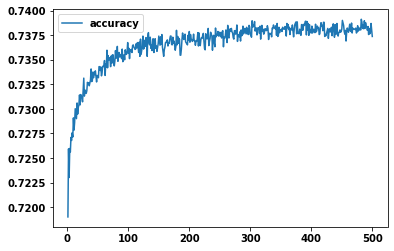

In [41]:
# Plot Accuracy
history_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))
history_df.plot(y="accuracy")

In [42]:
# Export our model to an HDF5 file
nn.save("AlphabetSoupCharity_Optimization2.h5")

### ATTEMPT 3: Increase bin count for 'CLASSIFICATION' rare occurances
* Return to original number of epochs- 100
* Maintain 3rd hidden layer
* number of hidden layers
* Return to original neuron count

In [43]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df = application_df.drop(columns=['EIN', 'NAME'], axis=1)

# bin APPLICATION_TYPE
app_type_count = application_df['APPLICATION_TYPE'].value_counts()

# Determine which values to replace if counts are less than ...?
replace_application = list(app_type_count[app_type_count <500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [44]:
classification_counts = application_df['CLASSIFICATION'].value_counts()

In [45]:
# Determine which values to replace if counts are less than ...?
replace_class_new = list(classification_counts[classification_counts <150].index)

# Replace in dataframe
for cls in replace_class_new:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1003
C7000      777
C1700      287
C4000      194
Name: CLASSIFICATION, dtype: int64

In [46]:
# Generate our categorical variable lists
application_cat= application_df.dtypes[application_df.dtypes == "object"].index.tolist()

# Confirm number of unique values for each category variable
application_df[application_cat].nunique()

APPLICATION_TYPE          9
AFFILIATION               6
CLASSIFICATION            9
USE_CASE                  5
ORGANIZATION              4
INCOME_AMT                9
SPECIAL_CONSIDERATIONS    2
dtype: int64

In [47]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [48]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
# Split our preprocessed data into our features and target arrays
X = application_df.drop(['IS_SUCCESSFUL'], 1).values
y = application_df['IS_SUCCESSFUL'].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [59]:
len(X_train_scaled[0])

46

In [60]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 40
hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               4700      
_________________________________________________________________
dense_15 (Dense)             (None, 40)                4040      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 9,161
Trainable params: 9,161
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [62]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_opt3/",exist_ok=True)
checkpoint_path = "checkpoints_opt3/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4020)

In [63]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 5s 4ms/step - loss: 0.5732 - accuracy: 0.7147
Epoch 2/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5521 - accuracy: 0.7297
Epoch 3/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5513 - accuracy: 0.7293
Epoch 4/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5499 - accuracy: 0.7320
Epoch 5/100
796/804 [============================>.] - ETA: 0s - loss: 0.5483 - accuracy: 0.7325
Epoch 00005: saving model to checkpoints_opt3\weights.05.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5480 - accuracy: 0.7325
Epoch 6/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5475 - accuracy: 0.7330
Epoch 7/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5460 - accuracy: 0.7338
Epoch 8/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5455 - accuracy: 0.7327
Epoch 9/100
804/804 [========================

804/804 [==============================] - 3s 4ms/step - loss: 0.5341 - accuracy: 0.7398
Epoch 64/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5341 - accuracy: 0.7402
Epoch 65/100
790/804 [============================>.] - ETA: 0s - loss: 0.5337 - accuracy: 0.7400
Epoch 00065: saving model to checkpoints_opt3\weights.65.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5334 - accuracy: 0.7403
Epoch 66/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5335 - accuracy: 0.7393
Epoch 67/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5335 - accuracy: 0.7399
Epoch 68/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5333 - accuracy: 0.7396
Epoch 69/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5334 - accuracy: 0.7407
Epoch 70/100
802/804 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.7405
Epoch 00070: saving model to checkpoints_opt3\weights.

In [64]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5655 - accuracy: 0.7291
Loss: 0.5655465722084045, Accuracy: 0.7290962338447571


In [65]:
# Export our model to an HDF5 file
nn.save("AlphabetSoupCharity_Optimization3.h5")

In [66]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 40


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               4700      
_________________________________________________________________
dense_19 (Dense)             (None, 40)                4040      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 41        
Total params: 8,781
Trainable params: 8,781
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [68]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_opt4/",exist_ok=True)
checkpoint_path = "checkpoints_opt4/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4020)

In [72]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[cp_callback])

Epoch 1/50
804/804 [==============================] - 3s 3ms/step - loss: 0.5298 - accuracy: 0.7419
Epoch 2/50
211/804 [======>.......................] - ETA: 2s - loss: 0.5240 - accuracy: 0.7445
Epoch 00002: saving model to checkpoints_opt4\weights.02.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5297 - accuracy: 0.7408
Epoch 3/50
804/804 [==============================] - 3s 4ms/step - loss: 0.5297 - accuracy: 0.7413
Epoch 4/50
804/804 [==============================] - 3s 3ms/step - loss: 0.5303 - accuracy: 0.7413
Epoch 5/50
804/804 [==============================] - 3s 3ms/step - loss: 0.5297 - accuracy: 0.7415
Epoch 6/50
804/804 [==============================] - 3s 3ms/step - loss: 0.5298 - accuracy: 0.7420
Epoch 7/50
209/804 [======>.......................] - ETA: 2s - loss: 0.5246 - accuracy: 0.7473
Epoch 00007: saving model to checkpoints_opt4\weights.07.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5293 - accuracy: 0.7418
Epoch 

<AxesSubplot:>

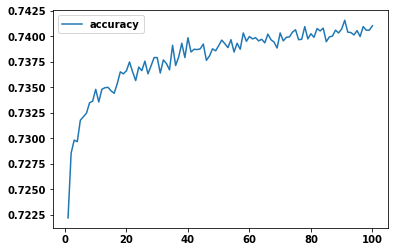

In [70]:
# Plot Accuracy
history_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))
history_df.plot(y="accuracy")

In [73]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5785 - accuracy: 0.7308
Loss: 0.5785437226295471, Accuracy: 0.7308454513549805
